In [1]:
import time
import sys
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from sklearn.decomposition import PCA
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '5e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--model-name', 'dentategyrus_model.cpt',
                               '--exp-name', 'CohAE_dentategyrus',
                               '--device', 'cuda:3',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("OPC", "OL")]
k_cluster = "clusters"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args):
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())

    model = get_veloAE(
                     adata, 
                     z_dim, 
                     n_genes, 
                     n_cells, 
                     h_dim, 
                     k_dim, 
                     G_embeddings=G_embeddings, 
                     g_rep_dim=g_rep_dim,
                     device=device
                    )
    model = model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    
    model.train()
    i, losses = 0, [sys.maxsize]
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_u, tensor_s, tensor_x], model, optimizer)                
        losses.append(loss)
        if i % args.log_interval == 0:
            plt.plot(losses[1:])
            display.clear_output(wait=True)
            plt.show()
            print("Train Epoch: {:2d} Loss: {:.6f}"
                  .format(i, losses[-1]))
    
    plt.plot(losses[1:])
    display.clear_output(wait=True)
    plt.show()
    print(losses[-1])
    torch.save(model.state_dict(), args.model_name)
    

In [6]:
adata = scv.datasets.dentategyrus()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.9 0.1]
Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:14) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 2930 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


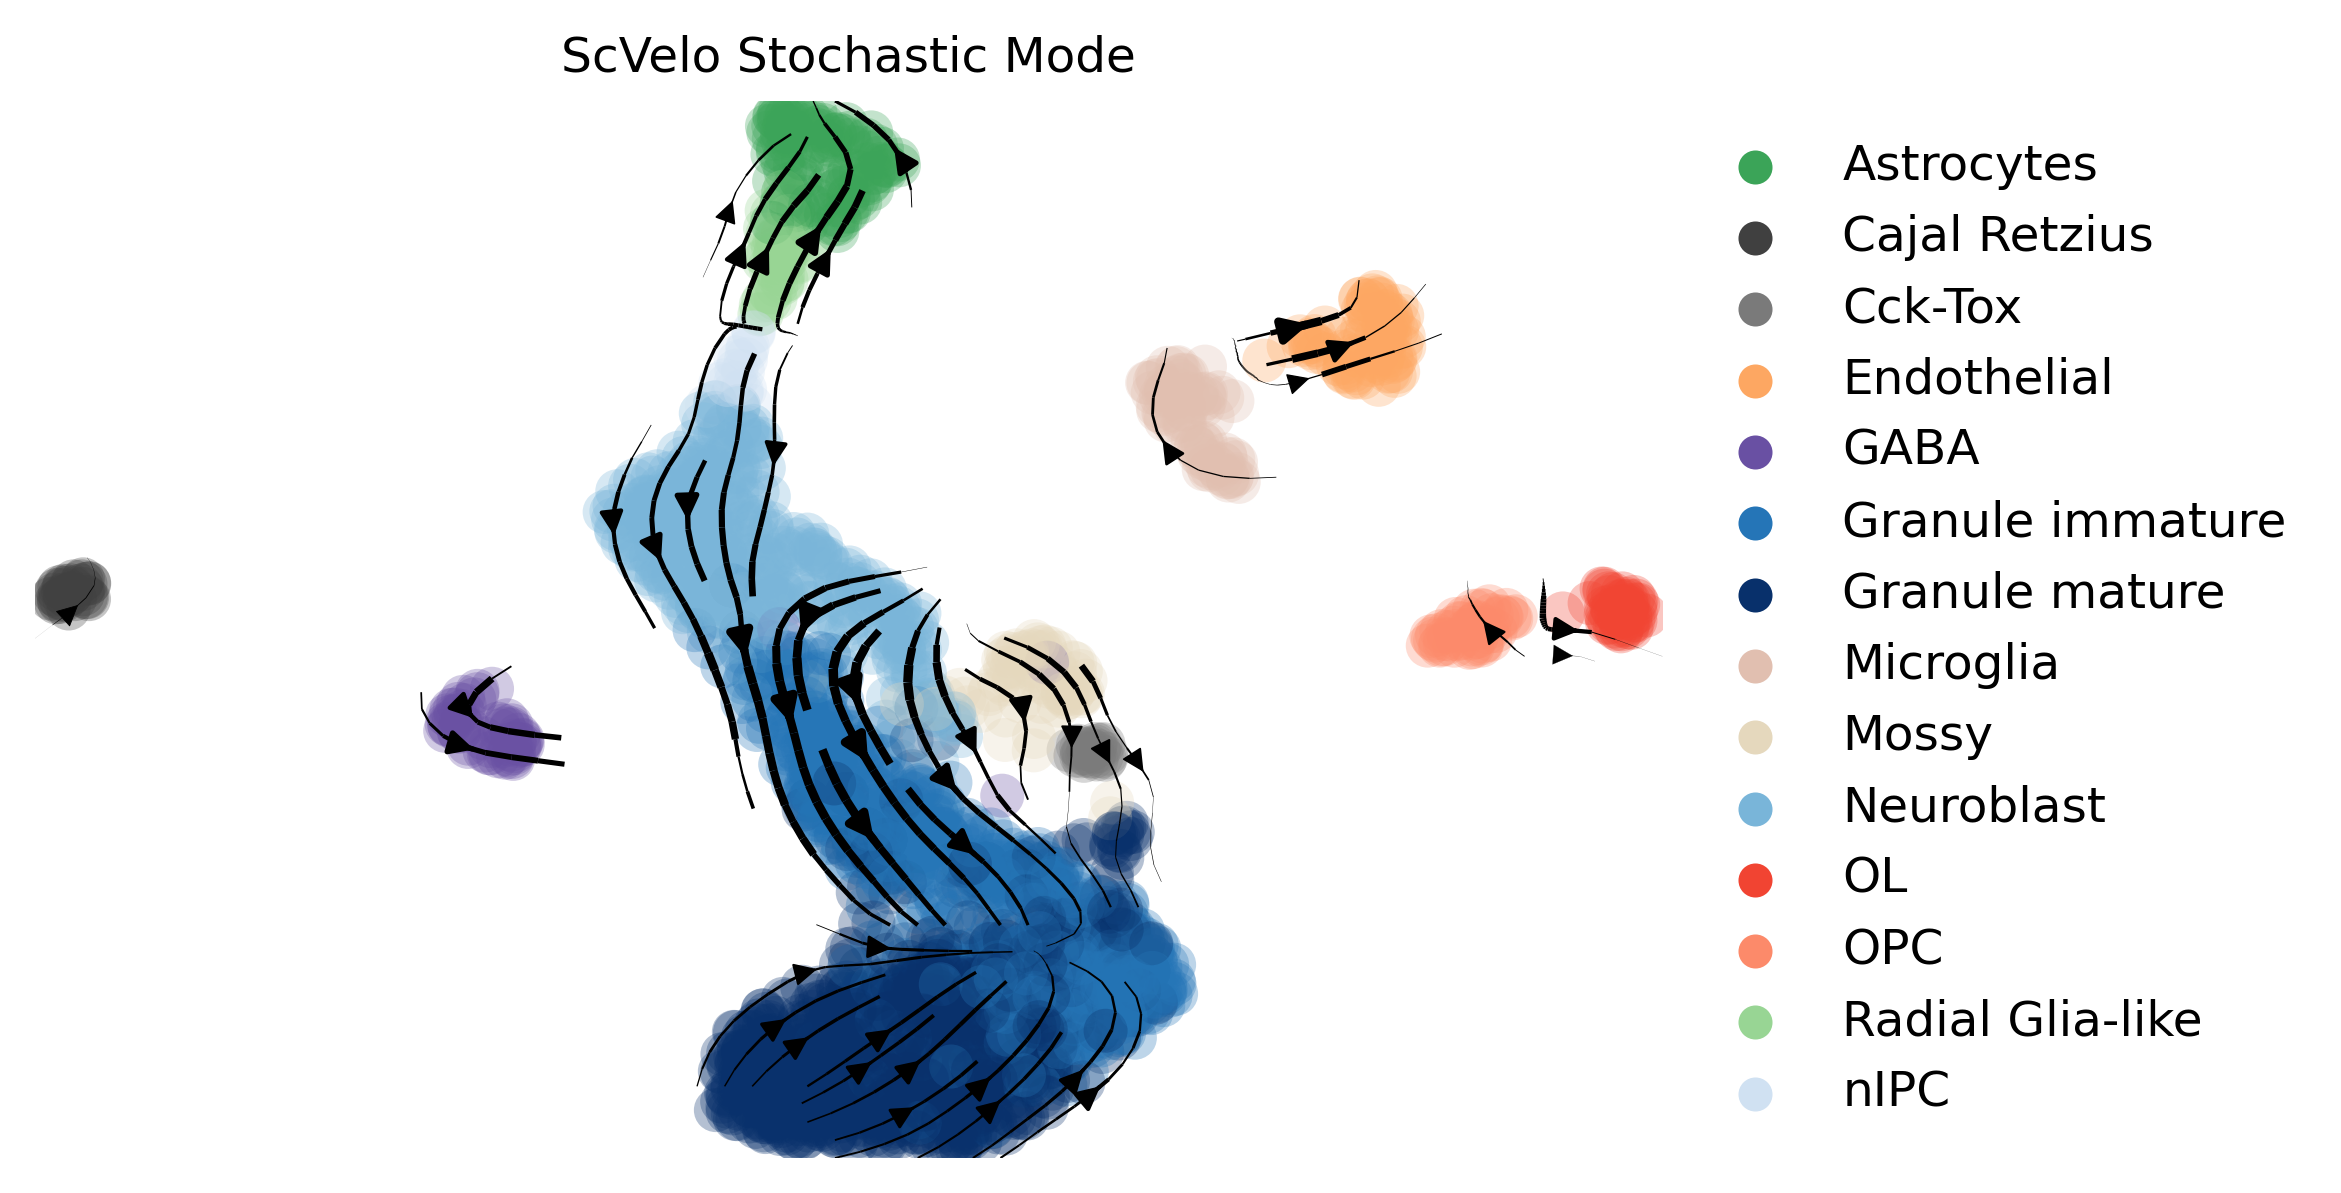

# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.5085378}
Total Mean: 0.5085378289222717
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.8861011346479906}
Total Mean: -0.8861011346479906
# In-cluster Coherence
{'Astrocytes': 0.8558933, 'Cajal Retzius': 0.9876432, 'Cck-Tox': 0.9481789, 'Endothelial': 0.9474042, 'GABA': 0.90869683, 'Granule immature': 0.8450072, 'Granule mature': 0.80969536, 'Microglia': 0.9754837, 'Mossy': 0.89986753, 'Neuroblast': 0.9308812, 'OL': 0.9506476, 'OPC': 0.92203844, 'Radial Glia-like': 0.89049774, 'nIPC': 0.94443244}
Total Mean: 0.9154548048973083
# In-cluster Confidence
{'Astrocytes': 0.892010415593783, 'Cajal Retzius': 0.9845344126224518, 'Cck-Tox': 0.8860587852972525, 'Endothelial': 0.8625854274322247, 'GABA': 0.8818325673947569, 'Granule immature': 0.8406926885531966, 'Granule mature': 0.8008263841967717, 'Microglia': 0.8768389931431523, 'Mossy': 0.

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  legend_loc="right margin", vkey="stc_velocity", basis='X_umap', color=['clusters'],# 'age(days)'],
                                 dpi=350, 
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

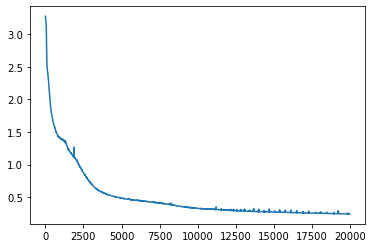

0.24187618494033813


In [9]:
main_AE(args)

In [10]:
n_cells, n_genes = adata.X.shape
z_dim = args.z_dim
g_rep_dim = args.g_rep_dim
h_dim = args.h_dim
k_dim = args.k_dim
    
G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
model = get_veloAE(
                 adata, 
                 z_dim, 
                 n_genes, 
                 n_cells, 
                 h_dim, 
                 k_dim, 
                 G_embeddings=G_embeddings, 
                 g_rep_dim=g_rep_dim,
                 device=device
                )
model = model.to(device)
model.load_state_dict(torch.load(args.model_name))

<All keys matched successfully>

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_dentategyrus_pojection.png


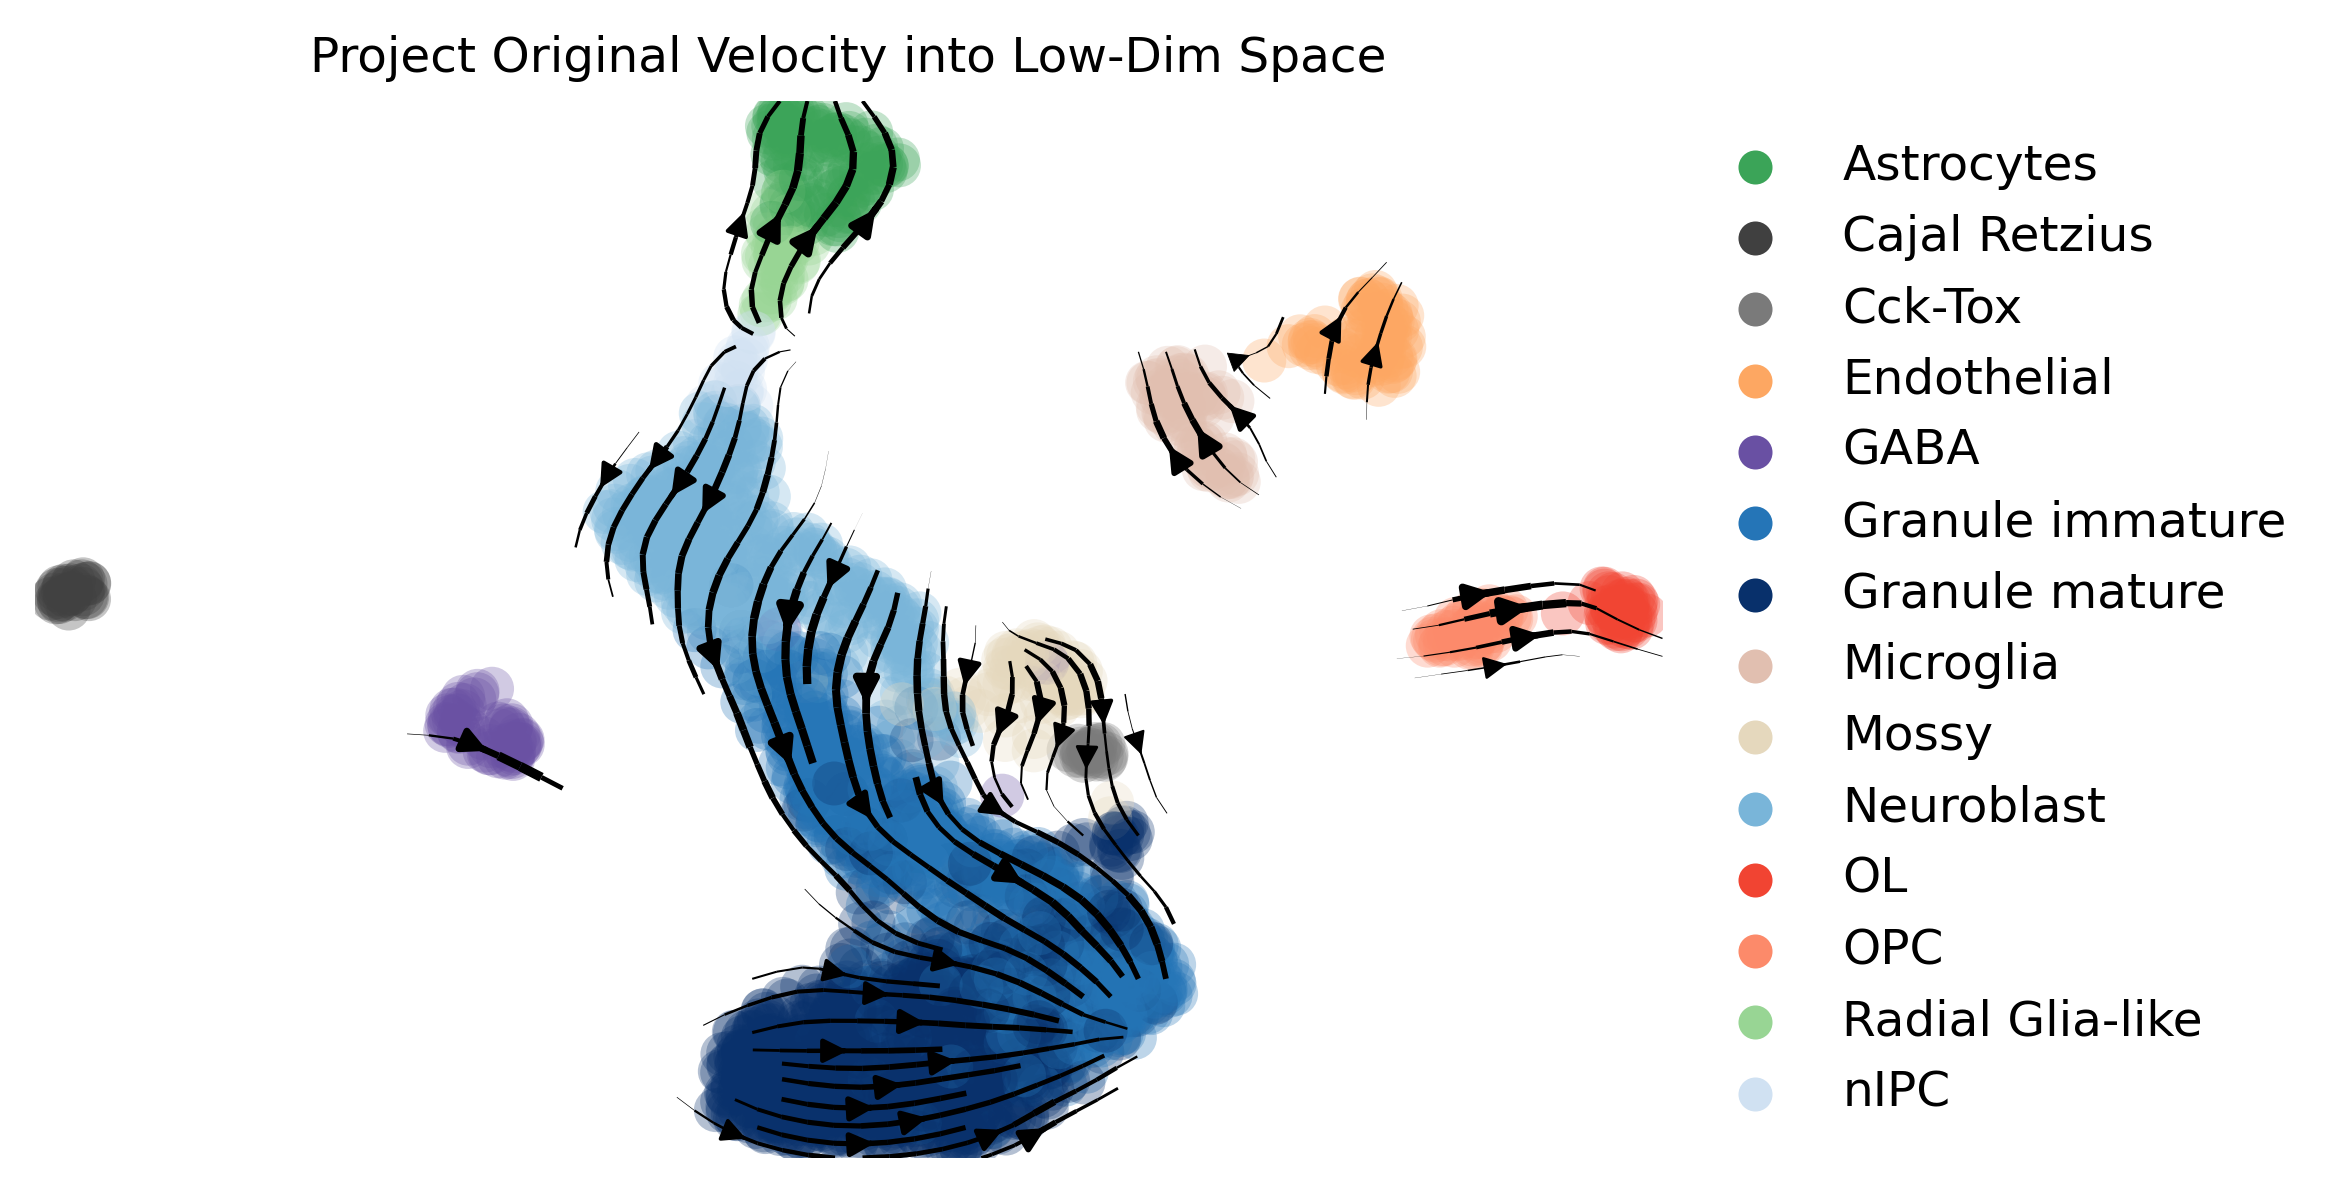

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.87337554}
Total Mean: 0.8733755350112915
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.9367271}
Total Mean: 0.9367271065711975
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): 0.9862757086197987}
Total Mean: 0.9862757086197987
# In-cluster Coherence
{'Astrocytes': 0.9918907, 'Cajal Retzius': 0.9992751, 'Cck-Tox': 0.99893945, 'Endothelial': 0.97057843, 'GABA': 0.99707127, 'Granule immature': 0.99830335, 'Granule mature': 0.9984463, 'Microglia': 0.9755324, 'Mossy': 0.99234366, 'Neuroblast': 0.99299765, 'OL': 0.9863474, 'OPC': 0.99796754, 'Radial Glia-like': 0.9917799, 'nIPC': 0.95683026}
Total Mean: 0.9891645312309265
# In-cluster Confidence
{'Astrocytes': 0.9912050008773804, 'Cajal Retzius': 0.9991021612111259, 'Cck-Tox': 0.9979760050773621, 'Endothelia

In [11]:
def exp(adata, exp_metrics):
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis='X_umap', color=['clusters'], #, 'age(days)'],
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='dentategyrus_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
exp(adata, exp_metrics)

In [12]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)